In [1]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

### load_breast_cancer

In [2]:
cancer = load_breast_cancer()
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [3]:
cancer.target;

In [4]:
# 0,1 중에서 어떤 것이 양성인지 확인해야한다!
cancer.target_names

array(['malignant', 'benign'], dtype='<U9')

In [5]:
data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [7]:
lr_clf = LogisticRegression()

In [8]:
knn_clf = KNeighborsClassifier(n_neighbors=8)

In [9]:
vo_clf = VotingClassifier([('LR', lr_clf), 
                           ('knn_clf', knn_clf)], voting='soft')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

In [11]:
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
accuracy_score(y_test, pred)

0.9473684210526315

In [12]:
vo_clf.score(X_test, y_test)

0.9473684210526315

In [13]:
classifiers = [lr_clf, knn_clf]

for classifier in classifiers :
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    print(f'{classifier.__class__.__name__} 정확도 : {accuracy_score(y_test, pred):.4f}')

LogisticRegression 정확도 : 0.9386
KNeighborsClassifier 정확도 : 0.9386


In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
def get_new_feature_name_df(old) :
    feature_dup_df = pd.DataFrame(data=old.groupby('column_name').cumcount(), 
                                  columns=['dup_cnt']) # cumcount 같은 데이터에 대해서 카운트 해준다.

    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old.reset_index(), feature_dup_df, how='outer')

    new_feature_name_df['column_name'] = new_feature_name_df[ ['column_name', 'dup_cnt'] ].apply(
        lambda x : x[0] + '_' + str(x[1]) if x[1] > 0 else x[0], axis=1 ) # 넘어오는 데이터 두개를 x로 받음. => 인덱싱으로 접근. x[0], x[1]
    new_feature_name_df = new_feature_name_df.drop(columns=['index'])
    
    return new_feature_name_df

---

### human_dataset

In [16]:
def get_human_dataset() :
    feature_name_df = pd.read_csv('./human_activity/features.txt', 
                              sep='\s+',
                              header=None, # 컬럼명 없을 때 None 사용
                              names=['column_index', 'column_name']
                             )
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    X_train = pd.read_csv('./human_activity/train/X_train.txt',
                          sep='\s+',
                          names=feature_name)
    
    X_test = pd.read_csv('./human_activity/test/X_test.txt',
                          sep='\s+',
                          names=feature_name)
    
    y_train = pd.read_csv('./human_activity/train/y_train.txt',
                          sep='\s+',
                          header=None,
                          names=['action'])
    
    y_test = pd.read_csv('./human_activity/test/y_test.txt',
                          sep='\s+',
                          header=None,
                          names=['action'])
    
    return X_train, X_test, y_train, y_test

In [17]:
# human_dataset 으로 데이터 변경됨!
X_train, X_test, y_train, y_test = get_human_dataset()

In [18]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy_score(y_test, pred)

0.9253478113335596

In [19]:
# rf_clf와 점수 비교
vo_clf = VotingClassifier([('LR', lr_clf), 
                           ('knn_clf', knn_clf),
                           ], voting='soft')
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
accuracy_score(y_test, pred)

0.9565659993213438

In [20]:
classifiers = [lr_clf, knn_clf]

for classifier in classifiers :
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    print(f'{classifier.__class__.__name__} 정확도 : {accuracy_score(y_test, pred):.4f}')

LogisticRegression 정확도 : 0.9593
KNeighborsClassifier 정확도 : 0.9074


---
## GridSearchCV

In [21]:
from sklearn.model_selection import GridSearchCV

In [24]:
%%time 

parms={
    'n_estimators': [100],
    'max_depth': [6,8,10,12],
    'min_samples_split': [8,12,18],
    'min_samples_leaf': [8,16,20],
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=parms, cv=2, n_jobs=-1)

grid_cv.fit(X_train,y_train)
grid_cv.best_params_, grid_cv.best_score_

Wall time: 17.7 s


({'max_depth': 10,
  'min_samples_leaf': 8,
  'min_samples_split': 18,
  'n_estimators': 100},
 0.9182535364526659)

In [26]:
rf_clf = RandomForestClassifier(
      max_depth = 10,
      min_samples_leaf = 8,
      min_samples_split = 18,
      n_estimators = 300, # 계속 늘린다고 계속 좋아지지 않느다. 오히려 떨어질 수도 있다.
      random_state=0)

rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy_score(y_test, pred)

0.9175432643366135

---

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [31]:
%%time
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print(f'GBM 정확도 : {gb_accuracy:.4f}')

GBM 정확도 : 0.9386
Wall time: 7min 38s


---
# XGB

In [34]:
import xgboost as xgb
from xgboost import XGBClassifier

import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [35]:
dataset = load_breast_cancer()

X_features = dataset.data
y_label = dataset.target

In [36]:
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0


In [37]:
dataset.target_names

array(['malignant', 'benign'], dtype='<U9')

In [38]:
# target 데이터의 비율 확인하기
cancer_df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

In [40]:
X_train.shape, X_test.shape

((455, 30), (114, 30))

In [41]:
# XGB는 DMatrix 만들어서 데이터를 넘겨줘야한다!
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [42]:
params = {
    'max_depth' : 3,
    'objective' : 'binary:logistic',
    'eval_metric' : 'logloss',
    'early_stoppings' : 100, # 100번 동안에 성능 개선이 없을 경우 멈춘다.
}

num_rounds = 400

wlist = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,
                      early_stopping_rounds=100,
                      evals=wlist)

[16:12:41] WARNING: ..\src\learner.cc:576: 
Parameters: { "early_stoppings" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.46775	eval-logloss:0.47984
[1]	train-logloss:0.33578	eval-logloss:0.36218
[2]	train-logloss:0.25254	eval-logloss:0.29004
[3]	train-logloss:0.19584	eval-logloss:0.23382
[4]	train-logloss:0.15664	eval-logloss:0.19901
[5]	train-logloss:0.12663	eval-logloss:0.17469
[6]	train-logloss:0.10353	eval-logloss:0.15549
[7]	train-logloss:0.08545	eval-logloss:0.13367
[8]	train-logloss:0.07277	eval-logloss:0.12411
[9]	train-logloss:0.06333	eval-logloss:0.11611
[10]	train-logloss:0.05484	eval-logloss:0.10768
[11]	train-logloss:0.04787	eval-logloss:0.10018
[12]	train-logloss:0.04334	eval-logloss:0.09754
[13]	train-logloss:0

In [43]:
pred_probs = xgb_model.predict(dtest)
pred_probs

array([9.7849441e-01, 3.8310601e-03, 9.4475126e-01, 5.4276973e-02,
       9.9449289e-01, 9.9998605e-01, 9.9978822e-01, 9.9959677e-01,
       9.9818242e-01, 7.6262520e-05, 8.5400556e-05, 8.7273998e-05,
       9.9985099e-01, 9.9994135e-01, 9.9899274e-01, 9.9138582e-01,
       9.9554789e-01, 9.9993980e-01, 9.9968743e-01, 9.9975663e-01,
       8.0555456e-04, 5.5488956e-01, 1.2712798e-04, 9.9998760e-01,
       1.5862775e-04, 6.6383767e-01, 2.2517648e-03, 1.5270994e-04,
       9.9968803e-01, 5.2804612e-02, 9.9891365e-01, 1.6868571e-04,
       9.9267286e-01, 7.9403830e-01, 1.2954368e-03, 5.3546857e-05,
       9.9951720e-01, 9.9932575e-01, 3.0032575e-01, 9.9990332e-01,
       1.1817576e-01, 9.9840575e-01, 9.9957114e-01, 9.9984813e-01,
       9.9951065e-01, 9.8719770e-01, 9.1385338e-03, 9.9985731e-01,
       9.9958748e-01, 9.9985397e-01, 9.9906081e-01, 2.7417587e-04,
       9.9958986e-01, 9.9991405e-01, 9.9980885e-01, 9.9966490e-01,
       9.9993479e-01, 9.9475622e-01, 9.9967134e-01, 9.7636569e

In [46]:
np.round(pred_probs, 3)[:20]

array([0.978, 0.004, 0.945, 0.054, 0.994, 1.   , 1.   , 1.   , 0.998,
       0.   , 0.   , 0.   , 1.   , 1.   , 0.999, 0.991, 0.996, 1.   ,
       1.   , 1.   ], dtype=float32)

In [47]:
preds = [1 if x > 0.5 else 0 for x in pred_probs]
preds[:10]

[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]

In [58]:
def get_clf_eval(y_test, pred, pred_proba) :
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)
    
    print('오차행렬')
    print(confusion)
    print()
    print(f'정확도 : {accuracy:.4f}, 정밀도 : {precision:.4f}, 재현율 : {recall:.4f}, F1 : {f1:.4f}, AUC : {auc:.4f}')

In [59]:
get_clf_eval(y_test, preds, pred_probs)

오차행렬
[[35  2]
 [ 2 75]]

정확도 : 0.9649, 정밀도 : 0.9740, 재현율 : 0.9740, F1 : 0.9740, AUC : 0.9961


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

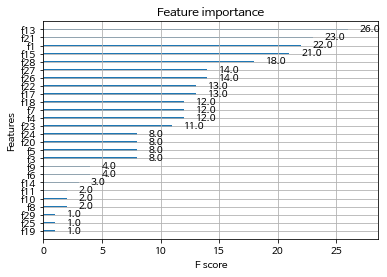

In [62]:
from xgboost import plot_importance

plot_importance(xgb_model)

---

In [63]:
from xgboost import XGBClassifier

In [64]:
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, w_preds, w_preds_proba)

[16:45:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
오차행렬
[[35  2]
 [ 1 76]]

정확도 : 0.9737, 정밀도 : 0.9744, 재현율 : 0.9870, F1 : 0.9806, AUC : 0.9951


In [66]:
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)

evals=[(X_test,y_test)]

xgb_wrapper.fit(X_train, y_train,
                early_stopping_rounds=100, 
                eval_metric='logloss', 
                eval_set=evals, 
                verbose=True)

w_preds = xgb_wrapper.predict(X_test)
w_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, w_preds, w_preds_proba)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [67]:
xgb_wrapper.fit(X_train, y_train,
                early_stopping_rounds=10, 
                eval_metric='logloss', 
                eval_set=evals, 
                verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, ws10_preds, ws10_preds_proba)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos